In [13]:

import numpy as np
import os
import torch
import torch.backends.cudnn
import torch.utils.data

import torchvision
import cv2 as cv
import cv2
import numpy as np

import random
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn


In [ ]:
IMG_SIZE = 224,224
CROP_SIZE = 128,128

# Transforms

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, rendering_images, bounding_box=None):
        for t in self.transforms:
            if t.__class__.__name__ == 'RandomCrop' or t.__class__.__name__ == 'CenterCrop':
                rendering_images = t(rendering_images, bounding_box)
            else:
                rendering_images = t(rendering_images)

        return rendering_images

In [ ]:
class ToTensor(object):

    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))
        array = np.transpose(rendering_images, (0, 3, 1, 2))
        # handle numpy array
        tensor = torch.from_numpy(array)

        # put it from HWC to CHW format
        return tensor.float()

In [ ]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))
        rendering_images -= self.mean
        rendering_images /= self.std

        return rendering_images

In [ ]:
class RandomPermuteRGB(object):
    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))

        random_permutation = np.random.permutation(3)
        for img_idx, img in enumerate(rendering_images):
            rendering_images[img_idx] = img[..., random_permutation]

        return rendering_images

In [ ]:
class CenterCrop(object):
    def __init__(self, img_size, crop_size):
        """Set the height and weight before and after cropping"""
        self.img_size_h = img_size[0]
        self.img_size_w = img_size[1]
        self.crop_size_h = crop_size[0]
        self.crop_size_w = crop_size[1]

    def __call__(self, rendering_images, bounding_box=None):
        if len(rendering_images) == 0:
            return rendering_images

        crop_size_c = rendering_images[0].shape[2]
        processed_images = np.empty(shape=(0, self.img_size_h, self.img_size_w, crop_size_c))
        for img_idx, img in enumerate(rendering_images):
            img_height, img_width, _ = img.shape

            if bounding_box is not None:
                bounding_box = [
                    bounding_box[0] * img_width,
                    bounding_box[1] * img_height,
                    bounding_box[2] * img_width,
                    bounding_box[3] * img_height
                ]  # yapf: disable

                # Calculate the size of bounding boxes
                bbox_width = bounding_box[2] - bounding_box[0]
                bbox_height = bounding_box[3] - bounding_box[1]
                bbox_x_mid = (bounding_box[2] + bounding_box[0]) * .5
                bbox_y_mid = (bounding_box[3] + bounding_box[1]) * .5

                # Make the crop area as a square
                square_object_size = max(bbox_width, bbox_height)
                x_left = int(bbox_x_mid - square_object_size * .5)
                x_right = int(bbox_x_mid + square_object_size * .5)
                y_top = int(bbox_y_mid - square_object_size * .5)
                y_bottom = int(bbox_y_mid + square_object_size * .5)

                # If the crop position is out of the image, fix it with padding
                pad_x_left = 0
                if x_left < 0:
                    pad_x_left = -x_left
                    x_left = 0
                pad_x_right = 0
                if x_right >= img_width:
                    pad_x_right = x_right - img_width + 1
                    x_right = img_width - 1
                pad_y_top = 0
                if y_top < 0:
                    pad_y_top = -y_top
                    y_top = 0
                pad_y_bottom = 0
                if y_bottom >= img_height:
                    pad_y_bottom = y_bottom - img_height + 1
                    y_bottom = img_height - 1

                # Padding the image and resize the image
                processed_image = np.pad(img[y_top:y_bottom + 1, x_left:x_right + 1],
                                         ((pad_y_top, pad_y_bottom), (pad_x_left, pad_x_right), (0, 0)),
                                         mode='edge')
                processed_image = cv2.resize(processed_image, (self.img_size_w, self.img_size_h))
            else:
                if img_height > self.crop_size_h and img_width > self.crop_size_w:
                    x_left = int(img_width - self.crop_size_w) // 2
                    x_right = int(x_left + self.crop_size_w)
                    y_top = int(img_height - self.crop_size_h) // 2
                    y_bottom = int(y_top + self.crop_size_h)
                else:
                    x_left = 0
                    x_right = img_width
                    y_top = 0
                    y_bottom = img_height

                processed_image = cv2.resize(img[y_top:y_bottom, x_left:x_right], (self.img_size_w, self.img_size_h))

            processed_images = np.append(processed_images, [processed_image], axis=0)
        return processed_images


In [ ]:
class RandomCrop(object):
    def __init__(self, img_size, crop_size):
        """Set the height and weight before and after cropping"""
        self.img_size_h = img_size[0]
        self.img_size_w = img_size[1]
        self.crop_size_h = crop_size[0]
        self.crop_size_w = crop_size[1]

    def __call__(self, rendering_images, bounding_box=None):
        if len(rendering_images) == 0:
            return rendering_images

        crop_size_c = rendering_images[0].shape[2]
        processed_images = np.empty(shape=(0, self.img_size_h, self.img_size_w, crop_size_c))
        for img_idx, img in enumerate(rendering_images):
            img_height, img_width, _ = img.shape

            if bounding_box is not None:
                bounding_box = [
                    bounding_box[0] * img_width,
                    bounding_box[1] * img_height,
                    bounding_box[2] * img_width,
                    bounding_box[3] * img_height
                ]  # yapf: disable

                # Calculate the size of bounding boxes
                bbox_width = bounding_box[2] - bounding_box[0]
                bbox_height = bounding_box[3] - bounding_box[1]
                bbox_x_mid = (bounding_box[2] + bounding_box[0]) * .5
                bbox_y_mid = (bounding_box[3] + bounding_box[1]) * .5

                # Make the crop area as a square
                square_object_size = max(bbox_width, bbox_height)
                square_object_size = square_object_size * random.uniform(0.8, 1.2)

                x_left = int(bbox_x_mid - square_object_size * random.uniform(.4, .6))
                x_right = int(bbox_x_mid + square_object_size * random.uniform(.4, .6))
                y_top = int(bbox_y_mid - square_object_size * random.uniform(.4, .6))
                y_bottom = int(bbox_y_mid + square_object_size * random.uniform(.4, .6))

                # If the crop position is out of the image, fix it with padding
                pad_x_left = 0
                if x_left < 0:
                    pad_x_left = -x_left
                    x_left = 0
                pad_x_right = 0
                if x_right >= img_width:
                    pad_x_right = x_right - img_width + 1
                    x_right = img_width - 1
                pad_y_top = 0
                if y_top < 0:
                    pad_y_top = -y_top
                    y_top = 0
                pad_y_bottom = 0
                if y_bottom >= img_height:
                    pad_y_bottom = y_bottom - img_height + 1
                    y_bottom = img_height - 1

                # Padding the image and resize the image
                processed_image = np.pad(img[y_top:y_bottom + 1, x_left:x_right + 1],
                                         ((pad_y_top, pad_y_bottom), (pad_x_left, pad_x_right), (0, 0)),
                                         mode='edge')
                processed_image = cv2.resize(processed_image, (self.img_size_w, self.img_size_h))
            else:
                if img_height > self.crop_size_h and img_width > self.crop_size_w:
                    x_left = int(img_width - self.crop_size_w) // 2
                    x_right = int(x_left + self.crop_size_w)
                    y_top = int(img_height - self.crop_size_h) // 2
                    y_bottom = int(y_top + self.crop_size_h)
                else:
                    x_left = 0
                    x_right = img_width
                    y_top = 0
                    y_bottom = img_height

                processed_image = cv2.resize(img[y_top:y_bottom, x_left:x_right], (self.img_size_w, self.img_size_h))

            processed_images = np.append(processed_images, [processed_image], axis=0)

        return processed_images


In [ ]:
class RandomFlip(object):
    def __call__(self, rendering_images):
        assert (isinstance(rendering_images, np.ndarray))

        for img_idx, img in enumerate(rendering_images):
            if random.randint(0, 1):
                rendering_images[img_idx] = np.fliplr(img)

        return rendering_images

In [ ]:
class ColorJitter(object):
    def __init__(self, brightness, contrast, saturation):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation

    def __call__(self, rendering_images):
        if len(rendering_images) == 0:
            return rendering_images

        # Allocate new space for storing processed images
        img_height, img_width, img_channels = rendering_images[0].shape
        processed_images = np.empty(shape=(0, img_height, img_width, img_channels))

        # Randomize the value of changing brightness, contrast, and saturation
        brightness = 1 + np.random.uniform(low=-self.brightness, high=self.brightness)
        contrast = 1 + np.random.uniform(low=-self.contrast, high=self.contrast)
        saturation = 1 + np.random.uniform(low=-self.saturation, high=self.saturation)

        # Randomize the order of changing brightness, contrast, and saturation
        attr_names = ['brightness', 'contrast', 'saturation']
        attr_values = [brightness, contrast, saturation]    # The value of changing attrs
        attr_indexes = np.array(range(len(attr_names)))    # The order of changing attrs
        np.random.shuffle(attr_indexes)

        for img_idx, img in enumerate(rendering_images):
            processed_image = img
            for idx in attr_indexes:
                processed_image = self._adjust_image_attr(processed_image, attr_names[idx], attr_values[idx])

            processed_images = np.append(processed_images, [processed_image], axis=0)

        return processed_images

    def _adjust_image_attr(self, img, attr_name, attr_value):

        gs = self._bgr_to_gray(img)

        if attr_name == 'contrast':
            img = self._alpha_blend(img, np.mean(gs[:, :, 0]), attr_value)
        elif attr_name == 'saturation':
            img = self._alpha_blend(img, gs, attr_value)
        elif attr_name == 'brightness':
            img = self._alpha_blend(img, 0, attr_value)
        else:
            raise NotImplementedError(attr_name)
        return img

    def _bgr_to_gray(self, bgr):

        ch = 0.114 * bgr[:, :, 0] + 0.587 * bgr[:, :, 1] + 0.299 * bgr[:, :, 2]
        gs = np.dstack((ch, ch, ch))
        return gs

    def _alpha_blend(self, im1, im2, alpha):
        im_blend = alpha * im1 + (1 - alpha) * im2
        return im_blend


In [ ]:
class RandomNoise(object):
    def __init__(self,
                 noise_std,
                 eigvals=(0.2175, 0.0188, 0.0045),
                 eigvecs=((-0.5675, 0.7192, 0.4009), (-0.5808, -0.0045, -0.8140), (-0.5836, -0.6948, 0.4203))):
        self.noise_std = noise_std
        self.eigvals = np.array(eigvals)
        self.eigvecs = np.array(eigvecs)

    def __call__(self, rendering_images):
        alpha = np.random.normal(loc=0, scale=self.noise_std, size=3)
        noise_rgb = \
            np.sum(
                np.multiply(
                    np.multiply(
                        self.eigvecs,
                        np.tile(alpha, (3, 1))
                    ),
                    np.tile(self.eigvals, (3, 1))
                ),
                axis=1
            )

        # Allocate new space for storing processed images
        img_height, img_width, img_channels = rendering_images[0].shape
        assert (img_channels == 3), "Please use RandomBackground to normalize image channels"
        processed_images = np.empty(shape=(0, img_height, img_width, img_channels))

        for img_idx, img in enumerate(rendering_images):
            processed_image = img[:, :, ::-1]    # BGR -> RGB
            for i in range(img_channels):
                processed_image[:, :, i] += noise_rgb[i]

            processed_image = processed_image[:, :, ::-1]    # RGB -> BGR
            processed_images = np.append(processed_images, [processed_image], axis=0)
        return processed_images


In [72]:
class RandomBackground(object):
    def __init__(self, random_bg_color_range, random_bg_folder_path=None):
        self.random_bg_color_range = random_bg_color_range
        self.random_bg_files = []
        if random_bg_folder_path is not None:
            self.random_bg_files = os.listdir(random_bg_folder_path)
            self.random_bg_files = [os.path.join(random_bg_folder_path, rbf) for rbf in self.random_bg_files]

    def __call__(self, rendering_images):
        if len(rendering_images) == 0:
            return rendering_images

        img_height, img_width, img_channels = rendering_images[0].shape
        # If the image has the alpha channel, add the background
        if not img_channels == 4:
            return rendering_images

        # Generate random background
        r, g, b = np.array([
            np.random.randint(self.random_bg_color_range[i][0], self.random_bg_color_range[i][1] + 1) for i in range(3)
        ]) / 255.

        random_bg = None
        if len(self.random_bg_files) > 0:
            random_bg_file_path = random.choice(self.random_bg_files)
            random_bg = cv2.imread(random_bg_file_path).astype(np.float32) / 255.

        # Apply random background
        processed_images = np.empty(shape=(0, img_height, img_width, img_channels - 1))
        for img_idx, img in enumerate(rendering_images):
            alpha = (np.expand_dims(img[:, :, 3], axis=2) == 0).astype(np.float32)
            img = img[:, :, :3]
            bg_color = random_bg if random.randint(0, 1) and random_bg is not None else np.array([[[r, g, b]]])
            img = alpha * bg_color + (1 - alpha) * img

            processed_images = np.append(processed_images, [img], axis=0)

        return processed_images


# Architecture

In [27]:
def get_volume_views(volume):
    volume = volume.squeeze().__ge__(0.5)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # Correct way to set up 3D axes
    ax.set_aspect('equal')
    ax.voxels(volume, edgecolor="k")
    
    # Display the generated plot in the notebook cell output
    plt.show()
    plt.close()

## Encoder

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Layer Definition
        vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)
        self.vgg = torch.nn.Sequential(*list(vgg16_bn.features.children()))[:27]
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=3),
            torch.nn.BatchNorm2d(512),
            torch.nn.ELU(),
            torch.nn.MaxPool2d(kernel_size=3)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ELU()
        )

        # Don't update params in VGG16
        for param in vgg16_bn.parameters():
            param.requires_grad = False

    def forward(self, rendering_images):
        # print(rendering_images.size())  # torch.Size([batch_size, n_views, img_c, img_h, img_w])
        rendering_images = rendering_images.permute(1, 0, 2, 3, 4).contiguous()
        rendering_images = torch.split(rendering_images, 1, dim=0)
        image_features = []

        for img in rendering_images:
            features = self.vgg(img.squeeze(dim=0))
            # print(features.size())    # torch.Size([batch_size, 512, 28, 28])
            features = self.layer1(features)
            # print(features.size())    # torch.Size([batch_size, 512, 26, 26])
            features = self.layer2(features)
            # print(features.size())    # torch.Size([batch_size, 512, 24, 24])
            features = self.layer3(features)
            # print(features.size())    # torch.Size([batch_size, 256, 8, 8])
            image_features.append(features)

        image_features = torch.stack(image_features).permute(1, 0, 2, 3, 4).contiguous()
        # print(image_features.size())  # torch.Size([batch_size, n_views, 256, 8, 8])
        return image_features

## Decoder

In [10]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(2048, 512, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(512),
            torch.nn.ReLU()
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(512, 128, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(128),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 8, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(8, 1, kernel_size=1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, image_features):
        image_features = image_features.permute(1, 0, 2, 3, 4).contiguous()
        image_features = torch.split(image_features, 1, dim=0)
        gen_volumes = []
        raw_features = []

        for features in image_features:
            gen_volume = features.view(-1, 2048, 2, 2, 2)
            # print(gen_volume.size())   # torch.Size([batch_size, 2048, 2, 2, 2])
            gen_volume = self.layer1(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 512, 4, 4, 4])
            gen_volume = self.layer2(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 128, 8, 8, 8])
            gen_volume = self.layer3(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 32, 16, 16, 16])
            gen_volume = self.layer4(gen_volume)
            raw_feature = gen_volume
            # print(gen_volume.size())   # torch.Size([batch_size, 8, 32, 32, 32])
            gen_volume = self.layer5(gen_volume)
            # print(gen_volume.size())   # torch.Size([batch_size, 1, 32, 32, 32])
            raw_feature = torch.cat((raw_feature, gen_volume), dim=1)
            # print(raw_feature.size())  # torch.Size([batch_size, 9, 32, 32, 32])

            gen_volumes.append(torch.squeeze(gen_volume, dim=1))
            raw_features.append(raw_feature)

        gen_volumes = torch.stack(gen_volumes).permute(1, 0, 2, 3, 4).contiguous()
        raw_features = torch.stack(raw_features).permute(1, 0, 2, 3, 4, 5).contiguous()
        # print(gen_volumes.size())      # torch.Size([batch_size, n_views, 32, 32, 32])
        # print(raw_features.size())     # torch.Size([batch_size, n_views, 9, 32, 32, 32])
        return raw_features, gen_volumes

## Merger

In [11]:
class Merger(torch.nn.Module):
    def __init__(self):
        super(Merger, self).__init__()

        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(9, 16, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(16),
            torch.nn.LeakyReLU(0.2)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(16, 8, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(8),
            torch.nn.LeakyReLU(0.2)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(8, 4, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(4),
            torch.nn.LeakyReLU(0.2)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(4, 2, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(2),
            torch.nn.LeakyReLU(0.2)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(2, 1, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(1),
            torch.nn.LeakyReLU(0.2)
        )

    def forward(self, raw_features, coarse_volumes):
        n_views_rendering = coarse_volumes.size(1)
        raw_features = torch.split(raw_features, 1, dim=1)
        volume_weights = []

        for i in range(n_views_rendering):
            raw_feature = torch.squeeze(raw_features[i], dim=1)
            # print(raw_feature.size())       # torch.Size([batch_size, 9, 32, 32, 32])

            volume_weight = self.layer1(raw_feature)
            # print(volume_weight.size())     # torch.Size([batch_size, 16, 32, 32, 32])
            volume_weight = self.layer2(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 8, 32, 32, 32])
            volume_weight = self.layer3(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 4, 32, 32, 32])
            volume_weight = self.layer4(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 2, 32, 32, 32])
            volume_weight = self.layer5(volume_weight)
            # print(volume_weight.size())     # torch.Size([batch_size, 1, 32, 32, 32])

            volume_weight = torch.squeeze(volume_weight, dim=1)
            # print(volume_weight.size())     # torch.Size([batch_size, 32, 32, 32])
            volume_weights.append(volume_weight)

        volume_weights = torch.stack(volume_weights).permute(1, 0, 2, 3, 4).contiguous()
        volume_weights = torch.softmax(volume_weights, dim=1)
        # print(volume_weights.size())        # torch.Size([batch_size, n_views, 32, 32, 32])
        # print(coarse_volumes.size())        # torch.Size([batch_size, n_views, 32, 32, 32])
        coarse_volumes = coarse_volumes * volume_weights
        coarse_volumes = torch.sum(coarse_volumes, dim=1)

        return torch.clamp(coarse_volumes, min=0, max=1)

## Refiner

In [12]:
class Refiner(torch.nn.Module):
    def __init__(self):
        super(Refiner, self).__init__()

        # Layer Definition
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, 32, kernel_size=4, padding=2),
            torch.nn.BatchNorm3d(32),
            torch.nn.LeakyReLU(0.2),
            torch.nn.MaxPool3d(kernel_size=2)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(32, 64, kernel_size=4, padding=2),
            torch.nn.BatchNorm3d(64),
            torch.nn.LeakyReLU(0.2),
            torch.nn.MaxPool3d(kernel_size=2)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 128, kernel_size=4, padding=2),
            torch.nn.BatchNorm3d(128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.MaxPool3d(kernel_size=2)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(8192, 2048),
            torch.nn.ReLU()
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Linear(2048, 8192),
            torch.nn.ReLU()
        )
        self.layer6 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(64),
            torch.nn.ReLU()
        )
        self.layer7 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm3d(32),
            torch.nn.ReLU()
        )
        self.layer8 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(32, 1, kernel_size=4, stride=2, bias=False, padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, coarse_volumes):
        volumes_32_l = coarse_volumes.view((-1, 1, 32, 32, 32))
        # print(volumes_32_l.size())       # torch.Size([batch_size, 1, 32, 32, 32])
        volumes_16_l = self.layer1(volumes_32_l)
        # print(volumes_16_l.size())       # torch.Size([batch_size, 32, 16, 16, 16])
        volumes_8_l = self.layer2(volumes_16_l)
        # print(volumes_8_l.size())        # torch.Size([batch_size, 64, 8, 8, 8])
        volumes_4_l = self.layer3(volumes_8_l)
        # print(volumes_4_l.size())        # torch.Size([batch_size, 128, 4, 4, 4])
        flatten_features = self.layer4(volumes_4_l.view(-1, 8192))
        # print(flatten_features.size())   # torch.Size([batch_size, 2048])
        flatten_features = self.layer5(flatten_features)
        # print(flatten_features.size())   # torch.Size([batch_size, 8192])
        volumes_4_r = volumes_4_l + flatten_features.view(-1, 128, 4, 4, 4)
        # print(volumes_4_r.size())        # torch.Size([batch_size, 128, 4, 4, 4])
        volumes_8_r = volumes_8_l + self.layer6(volumes_4_r)
        # print(volumes_8_r.size())        # torch.Size([batch_size, 64, 8, 8, 8])
        volumes_16_r = volumes_16_l + self.layer7(volumes_8_r)
        # print(volumes_16_r.size())       # torch.Size([batch_size, 32, 16, 16, 16])
        volumes_32_r = (volumes_32_l + self.layer8(volumes_16_r)) * 0.5
        # print(volumes_32_r.size())       # torch.Size([batch_size, 1, 32, 32, 32])

        return volumes_32_r.view((-1, 32, 32, 32))

# Inference

## First Trial

In [105]:
img=cv.imread("0093.png")
img=cv.resize(img,(224,224))
img=torch.from_numpy(img).float().view(-1,224,224)
img=img.unsqueeze(0).unsqueeze(0)

In [106]:
checkpoint = torch.load("Pix2Vox-A-ShapeNet.pth")

In [107]:
encoder=Encoder()
decoder=Decoder()
merger=Merger()
refiner=Refiner()

c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [108]:
if torch.cuda.is_available():
    encoder = torch.nn.DataParallel(encoder).cuda()
    decoder = torch.nn.DataParallel(decoder).cuda()
    merger  = torch.nn.DataParallel(merger).cuda()
    refiner = torch.nn.DataParallel(refiner).cuda()

In [109]:
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
merger.load_state_dict(checkpoint['merger_state_dict'])
refiner.load_state_dict(checkpoint['refiner_state_dict'])

<All keys matched successfully>

In [110]:
class model(nn.Module):
    def __init__(self,encoder,decoder,merger):
        super(model,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.merger=merger
    def forward(self,img):
        encoder=self.encoder.eval()
        decoder=self.decoder.eval()
        merger=self.merger.eval()
        image_features=encoder(img)
        raw_features, gen_voxels = decoder(image_features)
        final_output = merger(raw_features, gen_voxels)
        return final_output

In [111]:
Model = model(encoder,decoder,merger)

In [112]:
output=Model(img)

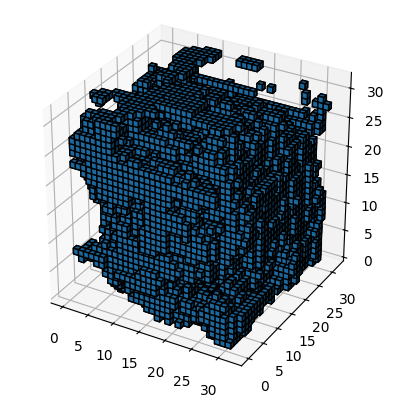

In [114]:
generated_volume1 = output.squeeze(0)

img_dir = '/sample_images'
gv = generated_volume1.cpu().detach().numpy()
gv=np.swapaxes(gv,0,2)
rendering_views = get_volume_views(gv)

## Second Trial

In [ ]:
encoder = Encoder()
decoder = Decoder()
refiner = Refiner()
merger = Merger()

WEIGHTS = 'Pix2Vox-A-ShapeNet.pth'
checkpoint = torch.load(WEIGHTS, map_location=torch.device('cpu'))

# Function to remove 'module.' prefix from state dict keys
def remove_module_prefix(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace('module.', '')  # remove `module.`
        new_state_dict[name] = v
    return new_state_dict

# Load model weights
encoder.load_state_dict(remove_module_prefix(checkpoint['encoder_state_dict']))
decoder.load_state_dict(remove_module_prefix(checkpoint['decoder_state_dict']))
merger.load_state_dict(remove_module_prefix(checkpoint['merger_state_dict']))
refiner.load_state_dict(remove_module_prefix(checkpoint['refiner_state_dict']))

epoch_idx = checkpoint['epoch_idx']

# Use GPU if available
if torch.cuda.is_available():
    encoder = torch.nn.DataParallel(encoder).cuda()
    decoder = torch.nn.DataParallel(decoder).cuda()
    merger  = torch.nn.DataParallel(merger).cuda()
    refiner = torch.nn.DataParallel(refiner).cuda()

# Set models to evaluation mode
encoder.eval()
decoder.eval()
refiner.eval()
merger.eval()

# Image preprocessing
img1_path = '1021a0914a7207aff927ed529ad90a11.png'
# img1_np = np.asarray(Image.open(img1_path))
# sample = np.array([img1_np])
img1_np = cv2.imread(img1_path)
img1_np = cv2.cvtColor(img1_np, cv2.COLOR_BGR2RGB)
sample = np.array([img1_np])
# Assuming `CenterCrop`, `RandomBackground`, `Normalize`, `ToTensor`, and `Compose` are defined correctly
IMG_SIZE = (224, 224)
CROP_SIZE = (128, 128)

test_transforms = Compose([
    CenterCrop(IMG_SIZE, CROP_SIZE),
    RandomBackground([[225, 255], [225, 255], [225, 255]]),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensor(),
])
# test_transforms = transforms.Compose([
#     transforms.Resize(IMG_SIZE),
#     transforms.CenterCrop(CROP_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# Apply the transformations
rendering_images = test_transforms(rendering_images=sample)  # Transform the image
rendering_images = rendering_images.unsqueeze(0)  # Add batch dimension

# Inference
with torch.no_grad():
    image_features = encoder(rendering_images)
    raw_features, generated_volume = decoder(image_features)

    # Use merger and refiner
    generated_volume = merger(raw_features, generated_volume)
    generated_volume = refiner(generated_volume)

In [ ]:
generated_volume.shape

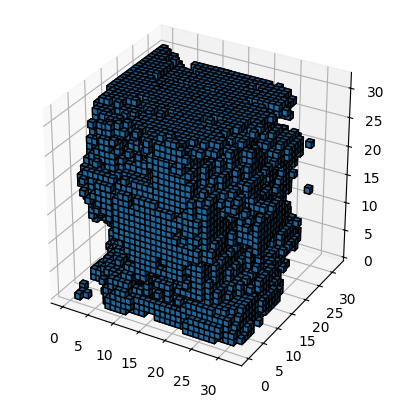

In [116]:
gv = generated_volume[0].detach().cpu().numpy()
gv=np.swapaxes(gv, 2, 1)

get_volume_views(gv)


## Third Trial

In [117]:
encoder = Encoder()
decoder = Decoder()
refiner = Refiner()
merger = Merger()

c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Seif Yasser\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
if torch.cuda.is_available():
    encoder = torch.nn.DataParallel(encoder).cuda()
    decoder = torch.nn.DataParallel(decoder).cuda()
    merger  = torch.nn.DataParallel(merger).cuda()
    refiner = torch.nn.DataParallel(refiner).cuda()

In [119]:
epoch_idx = checkpoint['epoch_idx']
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
 
if True:
    print('Use refiner')
    refiner.load_state_dict(checkpoint['refiner_state_dict'])
if True:
    print('Use merger')
    merger.load_state_dict(checkpoint['merger_state_dict'])
 
 

Use refiner
Use merger


In [120]:
encoder.eval()
decoder.eval()
refiner.eval()
merger.eval()

DataParallel(
  (module): Merger(
    (layer1): Sequential(
      (0): Conv3d(9, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer2): Sequential(
      (0): Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer3): Sequential(
      (0): Conv3d(8, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (layer4): Sequential(
      (0): Conv3d(4, 2, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(n

In [121]:
img1_path = 'Screenshot 2024-10-08 135321.png'
img1 = Image.open(img1_path).convert('RGB')
img1 = img1.resize((224, 224))
img1 = np.array(img1)  # Convert PIL Image to NumPy array
img = torch.from_numpy(img1).float().view(-1, 224, 224)
img = img.unsqueeze(0).unsqueeze(0)

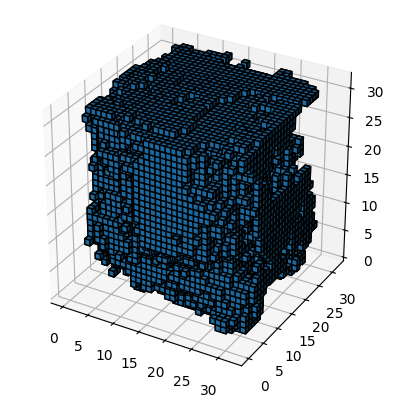

In [124]:

with torch.no_grad():
    image_features = encoder(img)
    raw_features, generated_volume = decoder(image_features)

    # if cfg.NETWORK.USE_MERGER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_MERGER:
    generated_volume = merger(raw_features, generated_volume)
    # else:
    # generated_volume = torch.mean(generated_volume, dim=1)

    # if cfg.NETWORK.USE_REFINER and epoch_idx >= cfg.TRAIN.EPOCH_START_USE_REFINER:
    generated_volume = refiner(generated_volume)

generated_volume = generated_volume.squeeze(0)
 
img_dir = './image_outputs'
gv = generated_volume.cpu().numpy()
gv_new = np.swapaxes(gv, 2, 1)
rendering_views = get_volume_views(gv_new)